In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('preprocessing')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# import viz

# prepare data

In [10]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
dsets = ['clath_aux+gak_new']
splits = ['test']

meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, _ = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta)

# load model
results = pkl.load(open('models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = np.vstack([x for x in df[track_name].values]) # input to the model (n x 40)
# this can be used for interpreting without normalization (n x 40)
X_unnormalized = np.vstack([x for x in df[track_name_unnormalized].values])
y = df['y_consec_thresh'].values

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


# interpret one pred at multiple scales
Calculates cd score for segments of different lengths. (e.g. each time point, half of inputs, etc.)
Input is length 40.

In [14]:
num = 100
xtrack = X[num: num + 1]
xtrack_unnormalized = X_unnormalized[num: num + 1]
xtrack_t = torch.tensor(np.array(list(xtrack)), dtype=torch.float)
pred = dnn.model(xtrack_t, None).item()

In [16]:
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[interpret.calc_cd_score(xtrack_t, None, s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]

100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


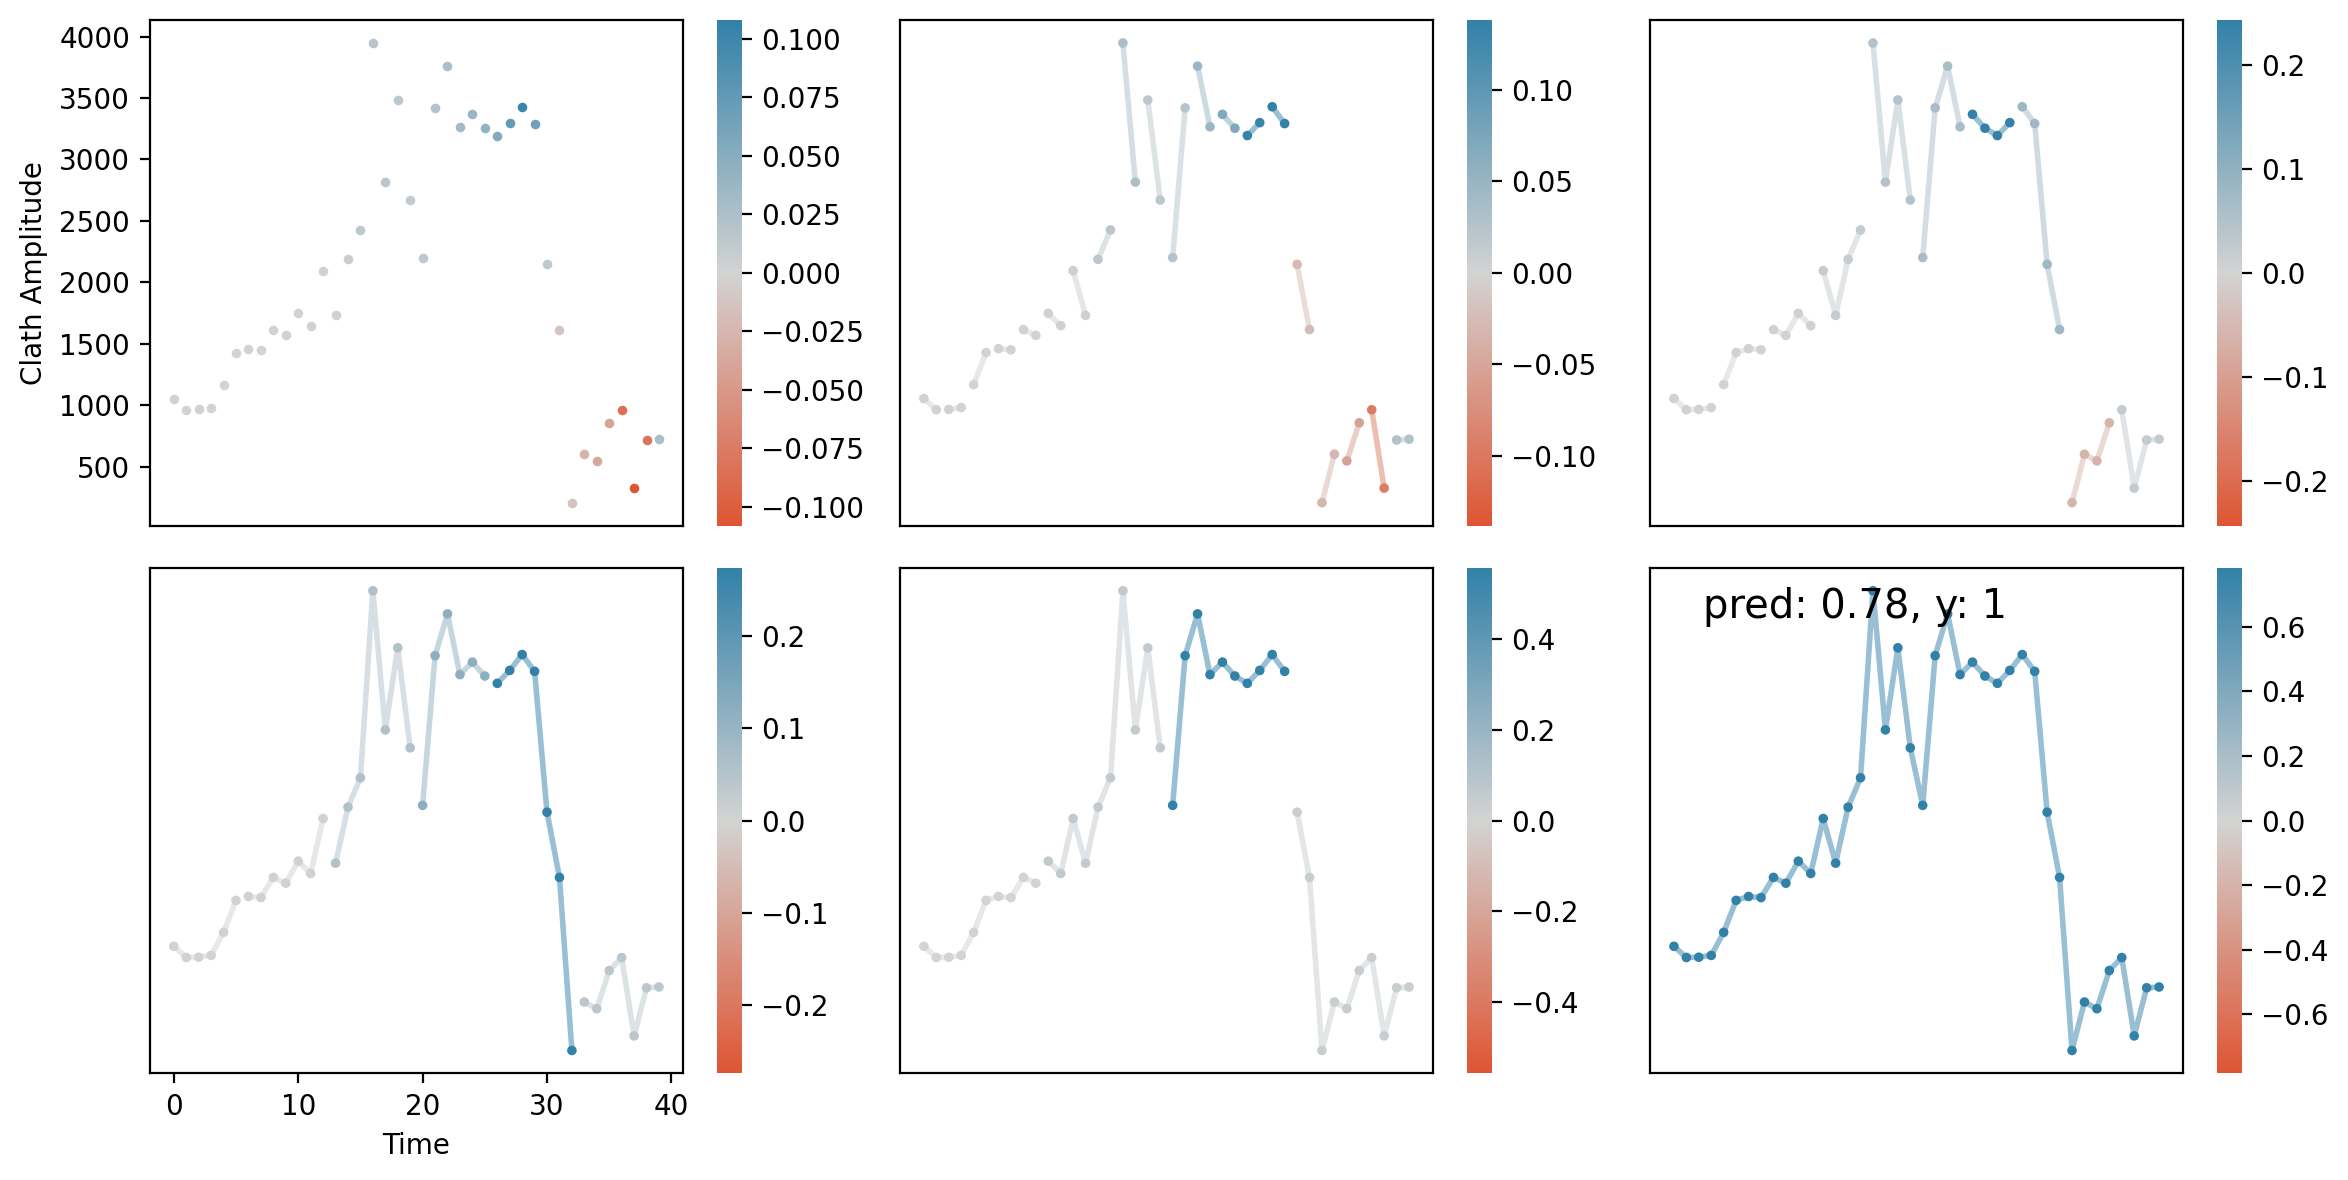

In [19]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    interpret.plot_segs(track_segs, cd_scores, xtrack_unnormalized[0]) #, pred, y=0)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i ==  C * R - 1:
        plt.text(0.1, 0.9,
                 f'pred: {pred:.2f}, y: {1 * y[num]}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()